# The Battle of L.A.’s Neighborhoods for a Well-Located Starbucks/Student-Focused Cafe

### A Capstone Project for the IBM® Applied Data Science Capstone | by Meghan Sills

The aim of this project is to help investors in finding the optimal location for opening a new student-focused cafe by giving them a nice visual overview of L.A.'s neighborhoods and their relevant characteristics. To this end, this notebook collects and combines several data sources about Los Angeles (e.g. housing prices, locations of universities, venues, and neighborhoods) and visualizes these on a geographical map of L.A. Based on this map, we will identify neighborhoods that meet the required criteria for the new cafe, i.e. close proximity to universities, low to moderate housing prices (for the area), livelihood of the area with other food & drink options, but not too many other cafés yet. Let's get started!

---

### **Table of contents:**
**1. Data collection and cleaning**<br>
1.1. Get names and geographical coordinates of L.A.'s universities<br>
1.2. Get names and geographical coordinates of L.A.'s neighborhoods<br>
1.3. Get housing prices of L.A.'s districts<br>
1.4. Combine housing price and location data of L.A.'s neighborhoods<br>
1.5. Get venue data of L.A.'s neighborhoods<br>
<br>
**2. Data exploration and analysis**<br>
2.1. Data exploration<br>
2.2. Clustering L.A.'s neighborhoods by venues<br>
2.3. Visualization of results in a Folium map

---

## Part 1: Data collection and cleaning
First, import all the dependencies that we will need.

In [1]:
import pandas as pd
import numpy as np
import requests # library to handle requests

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't installed geopy yet lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from sklearn.cluster import KMeans  # import k-means from clustering stage

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt

# use the inline backend to generate the plots within the browser
%matplotlib inline  

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Libraries imported.


### Part 1.1: Get names and geographical coordinates of L.A.'s universities
First, we get the names of Los Angeles area universities from the internet.

In [2]:
LA_unis = pd.read_html('https://www.universities.com/find/los-angeles/best')[0]

# Alternative: get data from my html file (in case the website is removed/modified)
# LA_unis = pd.read_html('LA_Unis.html')[0]  

LA_unis = LA_unis.iloc[0:10,1]
LA_unis

0       University of Southern California
1      California Institute of Technology
2    University of California-Los Angeles
3                   Pepperdine University
4         University of California-Irvine
5               Claremont McKenna College
6                      Occidental College
7                          Pomona College
8                      Chapman University
9                     Harvey Mudd College
Name: School Name, dtype: object

Then we get the geographical coordinates (latitude and longitude) of each university using the geopy client with the Nominatim service. Note that we use NaN values in case no result is returned.

In [3]:
la_unis = pd.DataFrame(columns=['University','Lat','Lon'])

for uni in LA_unis:
    
    address = uni + ', Los Angeles'
    geolocator = Nominatim(user_agent="la_explorer")
    location = geolocator.geocode(address)
    if location != None:
        latitude = location.latitude
        longitude = location.longitude
        la_unis = la_unis.append({'University': uni, 'Lat': latitude, 'Lon': longitude}, ignore_index=True)
    else:
        la_unis = la_unis.append({'University': uni, 'Lat': float('nan'), 'Lon': float('nan')}, ignore_index=True)
    
la_unis

,University,Lat,Lon
0,University of Southern California,34.022415,-118.286344
1,California Institute of Technology,34.137102,-118.125275
2,University of California-Los Angeles,34.070889,-118.446732
3,Pepperdine University,NaN,NaN
4,University of California-Irvine,NaN,NaN
5,Claremont McKenna College,34.102350,-117.706716
6,Occidental College,34.127334,-118.210520
7,Pomona College,34.094769,-117.714692
8,Chapman University,NaN,NaN
9,Harvey Mudd College,34.105993,-117.708709


As we see in the dataframe above, the geolocator did not return coordinates for 3 of the 9 universities. Therefore, we get and insert the latitude and longitude of these 3 universities manually using Google Maps.

In [4]:
# add/correct the remaining coordinates manually
la_unis.iloc[la_unis[la_unis.University=='Pepperdine University'].index,1] = float(34.0414)
la_unis.iloc[la_unis[la_unis.University=='Pepperdine University'].index,2] = float(-118.7096)

la_unis.iloc[la_unis[la_unis.University=='University of California-Irvine'].index,1] = float(33.6405)
la_unis.iloc[la_unis[la_unis.University=='University of California-Irvine'].index,2] = float(-117.8443)

la_unis.iloc[la_unis[la_unis.University=='Chapman University'].index,1] = float(33.7933)
la_unis.iloc[la_unis[la_unis.University=='Chapman University'].index,2] = float(-117.8514)

# Optional: Save the dataframe to a csv file as backup
# la_unis.to_csv('la_unis.csv',index=False)

la_unis

,University,Lat,Lon
0,University of Southern California,34.022415,-118.286344
1,California Institute of Technology,34.137102,-118.125275
2,University of California-Los Angeles,34.070889,-118.446732
3,Pepperdine University,34.041400,-118.709600
4,University of California-Irvine,33.640500,-117.844300
5,Claremont McKenna College,34.102350,-117.706716
6,Occidental College,34.127334,-118.210520
7,Pomona College,34.094769,-117.714692
8,Chapman University,33.793300,-117.851400
9,Harvey Mudd College,34.105993,-117.708709


### Part 1.2: Get names and geographical coordinates of L.A.'s neighborhoods
First, we download a geojson file with the names and geographical borders (latitudes and longitudes) of Southern California's neighborhoods.

In [5]:
# download Southern California's geojson file
!wget --quiet http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-v6.geojson -O la_neighborhoods.geojson
la_geo = r'la_neighborhoods.geojson' # geojson file

print('GeoJSON file downloaded!')

GeoJSON file downloaded!


Next, we read out the data contained in this geojson file and extract the names of all neighborhoods.

In [6]:
with open('la_neighborhoods.geojson') as json_data:
    la_json = json.load(json_data)
print('Done!')

Done!


In [7]:
# Get neighborhood names from geojson file
la_data = la_json['features']
neighborhoods_json = []

for data in la_data:
    neighborhood = data['properties']['name'] 
    neighborhoods_json.append(neighborhood)
    
print('The geojson file has', len(neighborhoods_json), 'neighborhoods.')
neighborhoods_json[0:5]

neighborhoods_json2 = pd.DataFrame(neighborhoods_json, columns=['Neighborhood'])
neighborhoods_json2

The geojson file has 318 neighborhoods.


,Neighborhood
0,Acton
1,Adams-Normandie
2,Agoura Hills
3,Agua Dulce
4,Alhambra
5,Aliso and Wood Regional Park
6,Aliso Viejo
7,Alondra Park
8,Altadena
9,Anaheim


### Part 1.3: Get rental prices of L.A.'s districts

First, we download a list of rental prices (in $/sqft) of L.A.'s neighborhoods for the year 2019 from the internet.

In [8]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_32a2e9c30c1e48ed8c0d7b066d1cda51 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='TENmOM4YrGnuoGazHula5gI6JUeiuk1gmGhohtSRvyph',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_32a2e9c30c1e48ed8c0d7b066d1cda51.get_object(Bucket='mydatascienceproject-donotdelete-pr-asv446u0bbiq8n',Key='ZillowPPSF.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body, dtype={'PPSF':int})
df_data_1.head()



,Neighborhood,City,State,CountyName,PPSF
0,South Los Angeles,Los Angeles,CA,Los Angeles County,387
1,Southeast Los Angeles,Los Angeles,CA,Los Angeles County,361
2,Hollywood,Los Angeles,CA,Los Angeles County,677
3,Koreatown,Los Angeles,CA,Los Angeles County,536
4,Westlake,Los Angeles,CA,Los Angeles County,561


In [9]:
la_Prices = df_data_1
la_Prices.reset_index(inplace=True, drop=True)
la_Prices.rename(columns={'PPSF':'Price'}, inplace=True)
la_Prices.drop(columns={'CountyName', 'City', 'State'}, inplace=True)
la_Prices.head()

,Neighborhood,Price
0,South Los Angeles,387
1,Southeast Los Angeles,361
2,Hollywood,677
3,Koreatown,536
4,Westlake,561


Now let's check the number of districts that are included in the resulting dataframe.

In [10]:
print('The la_Prices dataframe has', len(la_Prices.Neighborhood.values), 'neighborhoods.')
la_Prices.Neighborhood[0:5].tolist()

The la_Prices dataframe has 504 neighborhoods.


['South Los Angeles',
 'Southeast Los Angeles',
 'Hollywood',
 'Koreatown',
 'Westlake']

#### Part 1.4: Combine rental price and location data of L.A.'s neighborhoods.

While the geojson file only includes **318** neighborhoods, this dataframe includes **504** neighborhoods. Seems that prices are not available for all of L.A.'s neighborhoods. Since we want to combine both the location and price data later, we first check if all neighborhood names in the "la_Prices" dataframe match the neighborhood names obtained from the geojson file (see 1.2) and print the ones that do not match.

In [11]:
for n in neighborhoods_json:
    if (n not in la_Prices.Neighborhood):
        print(n)

Acton
Adams-Normandie
Agoura Hills
Agua Dulce
Alhambra
Aliso and Wood Regional Park
Aliso Viejo
Alondra Park
Altadena
Anaheim
Angeles Crest
Arcadia
Arleta
Arlington Heights
Artesia
Athens
Atwater Village
Avalon
Avocado Heights
Azusa
Baldwin Hills/Crenshaw
Baldwin Park
Bel-Air
Bellflower
Bell Gardens
Bell
Beverly Crest
Beverly Grove
Beverly Hills
Beverlywood
Boyle Heights
Bradbury
Brea
Brentwood
Broadway-Manchester
Buena Park
Burbank
Calabasas
Canoga Park
Carson
Carthay
Castaic Canyons
Castaic
Central-Alameda
Century City
Cerritos
Charter Oak
Chatsworth
Chatsworth Reservoir
Chesterfield Square
Cheviot Hills
Chinatown
Citrus
Claremont
Cleveland National Forest
Commerce
Compton
Costa Mesa
Coto de Caza
Covina
Cudahy
Culver City
Cypress
Cypress Park
Dana Point
Del Aire
Del Rey
Desert View Highlands
Diamond Bar
Downey
Downtown
Duarte
Eagle Rock
East Compton
East Hollywood
East Los Angeles
East Pasadena
East San Gabriel
East Whittier
Echo Park
Elizabeth Lake
El Monte
El Segundo
El Sereno
Elys

In [12]:

la_Data = pd.merge(la_Prices, neighborhoods_json2, how='inner', on=None, left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)


la_Data = la_Data.groupby('Neighborhood').mean()
la_Data.reset_index(inplace=True)


la_Data['Price'] = la_Data['Price'].astype(int)
la_Data


,Neighborhood,Price
0,Adams-Normandie,424
1,Arleta,377
2,Arlington Heights,250
3,Atwater Village,805
4,Beverly Crest,982
5,Beverlywood,979
6,Boyle Heights,422
7,Brentwood,1039
8,Canoga Park,379
9,Century City,765


In [13]:
la_data = pd.DataFrame(columns=['Neighborhood','Price','Lat','Lon'])

la_data = la_Data.iloc[0:80, 0:3]


for neighborhood in la_Data:
        
    address = neighborhood + ', Los Angeles, CA'
    geolocator = Nominatim(user_agent="la_explorer")
    location = geolocator.geocode(address)
    if location != None:
        latitude = location.latitude
        longitude = location.longitude
        hh = la_data.append({'Lat': latitude, 'Lon': longitude}, ignore_index=True)
    else:
        hh = la_data.append({'Lat': float('nan'), 'Lon': float('nan')}, ignore_index=True)
    
    
    latitude = location.latitude
    longitude = location.longitude
    hh = la_data.append({'Lat': latitude, 'Lon': longitude}, ignore_index=True)

hh.drop(80, inplace=True)
hh['Price'] = hh['Price'].astype(int)
        
hh


,Neighborhood,Price,Lat,Lon
0,Adams-Normandie,424,NaN,NaN
1,Arleta,377,NaN,NaN
2,Arlington Heights,250,NaN,NaN
3,Atwater Village,805,NaN,NaN
4,Beverly Crest,982,NaN,NaN
5,Beverlywood,979,NaN,NaN
6,Boyle Heights,422,NaN,NaN
7,Brentwood,1039,NaN,NaN
8,Canoga Park,379,NaN,NaN
9,Century City,765,NaN,NaN


As we see in the dataframe above, the geolocator did not return coordinates for **all** of the 80 neighborhoods. Therefore, we get and insert the latitude and longitude of all neighborhoods manually using Google Maps.

In [14]:
hh.iloc[hh[hh.Neighborhood=='Adams-Normandie'].index,2] = float(34.0326)
hh.iloc[hh[hh.Neighborhood=='Adams-Normandie'].index,3] = float(-118.3000)

hh.iloc[hh[hh.Neighborhood=='Arleta'].index,2] = float(34.2505)
hh.iloc[hh[hh.Neighborhood=='Arleta'].index,3] = float(-118.4338)

hh.iloc[hh[hh.Neighborhood=='Arlington Heights'].index,2] = float(34.0422)
hh.iloc[hh[hh.Neighborhood=='Arlington Heights'].index,3] = float(-118.3189)

hh.iloc[hh[hh.Neighborhood=='Atwater Village'].index,2] = float(34.1173)
hh.iloc[hh[hh.Neighborhood=='Atwater Village'].index,3] = float(-118.2614)

hh.iloc[hh[hh.Neighborhood=='Beverly Crest'].index,2] = float(34.1160)
hh.iloc[hh[hh.Neighborhood=='Beverly Crest'].index,3] = float(-118.4070)

hh.iloc[hh[hh.Neighborhood=='Beverlywood'].index,2] = float(34.0494)
hh.iloc[hh[hh.Neighborhood=='Beverlywood'].index,3] = float(-118.3952)

hh.iloc[hh[hh.Neighborhood=='Boyle Heights'].index,2] = float(34.0298)
hh.iloc[hh[hh.Neighborhood=='Boyle Heights'].index,3] = float(-118.2117)

hh.iloc[hh[hh.Neighborhood=='Brentwood'].index,2] = float(34.0521)
hh.iloc[hh[hh.Neighborhood=='Brentwood'].index,3] = float(-118.4732)

hh.iloc[hh[hh.Neighborhood=='Canoga Park'].index,2] = float(34.2083)
hh.iloc[hh[hh.Neighborhood=='Canoga Park'].index,3] = float(-118.6059)

hh.iloc[hh[hh.Neighborhood=='Century City'].index,2] = float(34.0537)
hh.iloc[hh[hh.Neighborhood=='Century City'].index,3] = float(-118.4134)

hh.iloc[hh[hh.Neighborhood=='Chatsworth'].index,2] = float(34.2506)
hh.iloc[hh[hh.Neighborhood=='Chatsworth'].index,3] = float(-118.6148)

hh.iloc[hh[hh.Neighborhood=='Cheviot Hills'].index,2] = float(34.0403)
hh.iloc[hh[hh.Neighborhood=='Cheviot Hills'].index,3] = float(-118.4042)

hh.iloc[hh[hh.Neighborhood=='Cypress'].index,2] = float(34.0922)
hh.iloc[hh[hh.Neighborhood=='Cypress'].index,3] = float(-118.2245)

hh.iloc[hh[hh.Neighborhood=='Cypress Park'].index,2] = float(34.0922)
hh.iloc[hh[hh.Neighborhood=='Cypress Park'].index,3] = float(-118.2245)

hh.iloc[hh[hh.Neighborhood=='Del Rey'].index,2] = float(33.9860)
hh.iloc[hh[hh.Neighborhood=='Del Rey'].index,3] = float(-118.4249)

hh.iloc[hh[hh.Neighborhood=='Downtown'].index,2] = float(34.0407)
hh.iloc[hh[hh.Neighborhood=='Downtown'].index,3] = float(-118.2468)

hh.iloc[hh[hh.Neighborhood=='Eagle Rock'].index,2] = float(34.1392)
hh.iloc[hh[hh.Neighborhood=='Eagle Rock'].index,3] = float(-118.2141)

hh.iloc[hh[hh.Neighborhood=='Echo Park'].index,2] = float(34.0782)
hh.iloc[hh[hh.Neighborhood=='Echo Park'].index,3] = float(-118.2606)

hh.iloc[hh[hh.Neighborhood=='El Sereno'].index,2] = float(34.0736)
hh.iloc[hh[hh.Neighborhood=='El Sereno'].index,3] = float(-118.1786)

hh.iloc[hh[hh.Neighborhood=='Elysian Valley'].index,2] = float(34.0991)
hh.iloc[hh[hh.Neighborhood=='Elysian Valley'].index,3] = float(-118.2450)

hh.iloc[hh[hh.Neighborhood=='Encino'].index,2] = float(34.1517)
hh.iloc[hh[hh.Neighborhood=='Encino'].index,3] = float(-118.5214)

hh.iloc[hh[hh.Neighborhood=='Glassell Park'].index,2] = float(34.1090)
hh.iloc[hh[hh.Neighborhood=='Glassell Park'].index,3] = float(-118.2334)

hh.iloc[hh[hh.Neighborhood=='Granada Hills'].index,2] = float(34.2794)
hh.iloc[hh[hh.Neighborhood=='Granada Hills'].index,3] = float(-118.5022)

hh.iloc[hh[hh.Neighborhood=='Harbor City'].index,2] = float(33.7907)
hh.iloc[hh[hh.Neighborhood=='Harbor City'].index,3] = float(-118.2965)

hh.iloc[hh[hh.Neighborhood=='Harbor Gateway'].index,2] = float(33.8405)
hh.iloc[hh[hh.Neighborhood=='Harbor Gateway'].index,3] = float(-118.3024)

hh.iloc[hh[hh.Neighborhood=='Harvard Heights'].index,2] = float(34.0422)
hh.iloc[hh[hh.Neighborhood=='Harvard Heights'].index,3] = float(-118.3042)

hh.iloc[hh[hh.Neighborhood=='Highland Park'].index,2] = float(34.1158)
hh.iloc[hh[hh.Neighborhood=='Highland Park'].index,3] = float(-118.1854)

hh.iloc[hh[hh.Neighborhood=='Hollywood'].index,2] = float(34.0928)
hh.iloc[hh[hh.Neighborhood=='Hollywood'].index,3] = float(-118.3287)

hh.iloc[hh[hh.Neighborhood=='Hollywood Hills'].index,2] = float(34.1177)
hh.iloc[hh[hh.Neighborhood=='Hollywood Hills'].index,3] = float(-118.3520)

hh.iloc[hh[hh.Neighborhood=='Hyde Park'].index,2] = float(33.9806)
hh.iloc[hh[hh.Neighborhood=='Hyde Park'].index,3] = float(-118.3306)

hh.iloc[hh[hh.Neighborhood=='Jefferson Park'].index,2] = float(34.0272)
hh.iloc[hh[hh.Neighborhood=='Jefferson Park'].index,3] = float(-118.3176)

hh.iloc[hh[hh.Neighborhood=='Koreatown'].index,2] = float(34.0610)
hh.iloc[hh[hh.Neighborhood=='Koreatown'].index,3] = float(-118.3024)

hh.iloc[hh[hh.Neighborhood=='Lake Balboa'].index,2] = float(34.2011)
hh.iloc[hh[hh.Neighborhood=='Lake Balboa'].index,3] = float(-118.5011)

hh.iloc[hh[hh.Neighborhood=='Las Flores'].index,2] = float(34.0372)
hh.iloc[hh[hh.Neighborhood=='Las Flores'].index,3] = float(-118.6359)

hh.iloc[hh[hh.Neighborhood=='Leimert Park'].index,2] = float(34.0107)
hh.iloc[hh[hh.Neighborhood=='Leimert Park'].index,3] = float(-118.3235)

hh.iloc[hh[hh.Neighborhood=='Lincoln Heights'].index,2] = float(34.0739)
hh.iloc[hh[hh.Neighborhood=='Lincoln Heights'].index,3] = float(-118.2136)

hh.iloc[hh[hh.Neighborhood=='Los Feliz'].index,2] = float(34.1063)
hh.iloc[hh[hh.Neighborhood=='Los Feliz'].index,3] = float(-118.2848)

hh.iloc[hh[hh.Neighborhood=='Mar Vista'].index,2] = float(34.0153)
hh.iloc[hh[hh.Neighborhood=='Mar Vista'].index,3] = float(-118.4338)

hh.iloc[hh[hh.Neighborhood=='Mid-City'].index,2] = float(34.0416)
hh.iloc[hh[hh.Neighborhood=='Mid-City'].index,3] = float(-118.3287)

hh.iloc[hh[hh.Neighborhood=='Mission Hills'].index,2] = float(34.2723)
hh.iloc[hh[hh.Neighborhood=='Mission Hills'].index,3] = float(-118.4689)

hh.iloc[hh[hh.Neighborhood=='Montecito Heights'].index,2] = float(34.0737)
hh.iloc[hh[hh.Neighborhood=='Montecito Heights'].index,3] = float(-118.2105)

hh.iloc[hh[hh.Neighborhood=='Mount Washington'].index,2] = float(34.0992)
hh.iloc[hh[hh.Neighborhood=='Mount Washington'].index,3] = float(-118.2204)

hh.iloc[hh[hh.Neighborhood=='North Hills'].index,2] = float(34.2358)
hh.iloc[hh[hh.Neighborhood=='North Hills'].index,3] = float(-118.4849)

hh.iloc[hh[hh.Neighborhood=='North Hollywood'].index,2] = float(34.1870)
hh.iloc[hh[hh.Neighborhood=='North Hollywood'].index,3] = float(-118.3813)

hh.iloc[hh[hh.Neighborhood=='Northridge'].index,2] = float(34.2381)
hh.iloc[hh[hh.Neighborhood=='Northridge'].index,3] = float(-118.5301)

hh.iloc[hh[hh.Neighborhood=='Pacific Palisades'].index,2] = float(34.0356)
hh.iloc[hh[hh.Neighborhood=='Pacific Palisades'].index,3] = float(-118.5156)

hh.iloc[hh[hh.Neighborhood=='Pacoima'].index,2] = float(34.2768)
hh.iloc[hh[hh.Neighborhood=='Pacoima'].index,3] = float(-118.4105)

hh.iloc[hh[hh.Neighborhood=='Palms'].index,2] = float(34.0244)
hh.iloc[hh[hh.Neighborhood=='Palms'].index,3] = float(-118.4075)

hh.iloc[hh[hh.Neighborhood=='Panorama City'].index,2] = float(34.2276)
hh.iloc[hh[hh.Neighborhood=='Panorama City'].index,3] = float(-118.4424)

hh.iloc[hh[hh.Neighborhood=='Pico-Robertson'].index,2] = float(34.0557)
hh.iloc[hh[hh.Neighborhood=='Pico-Robertson'].index,3] = float(-118.3798)

hh.iloc[hh[hh.Neighborhood=='Pico-Union'].index,2] = float(34.0443)
hh.iloc[hh[hh.Neighborhood=='Pico-Union'].index,3] = float(-118.2892)

hh.iloc[hh[hh.Neighborhood=='Playa Vista'].index,2] = float(33.9754)
hh.iloc[hh[hh.Neighborhood=='Playa Vista'].index,3] = float(-118.4192)

hh.iloc[hh[hh.Neighborhood=='Porter Ranch'].index,2] = float(34.2822)
hh.iloc[hh[hh.Neighborhood=='Porter Ranch'].index,3] = float(-118.5506)

hh.iloc[hh[hh.Neighborhood=='Reseda'].index,2] = float(34.2011)
hh.iloc[hh[hh.Neighborhood=='Reseda'].index,3] = float(-118.5361)

hh.iloc[hh[hh.Neighborhood=='San Pedro'].index,2] = float(33.7361)
hh.iloc[hh[hh.Neighborhood=='San Pedro'].index,3] = float(-118.2922)

hh.iloc[hh[hh.Neighborhood=='Sawtelle'].index,2] = float(34.2505)
hh.iloc[hh[hh.Neighborhood=='Sawtelle'].index,3] = float(-118.4338)

hh.iloc[hh[hh.Neighborhood=='Shadow Hills'].index,2] = float(34.2575)
hh.iloc[hh[hh.Neighborhood=='Shadow Hills'].index,3] = float(-118.3550)

hh.iloc[hh[hh.Neighborhood=='Sherman Oaks'].index,2] = float(34.1490)
hh.iloc[hh[hh.Neighborhood=='Sherman Oaks'].index,3] = float(-118.4514)

hh.iloc[hh[hh.Neighborhood=='Silver Lake'].index,2] = float(34.0869)
hh.iloc[hh[hh.Neighborhood=='Silver Lake'].index,3] = float(-118.2702)

hh.iloc[hh[hh.Neighborhood=='Studio City'].index,2] = float(34.1396)
hh.iloc[hh[hh.Neighborhood=='Studio City'].index,3] = float(-118.3871)

hh.iloc[hh[hh.Neighborhood=='Sun Valley'].index,2] = float(34.2279)
hh.iloc[hh[hh.Neighborhood=='Sun Valley'].index,3] = float(-118.3813)

hh.iloc[hh[hh.Neighborhood=='Sunland'].index,2] = float(34.2596)
hh.iloc[hh[hh.Neighborhood=='Sunland'].index,3] = float(-118.3083)

hh.iloc[hh[hh.Neighborhood=='Sylmar'].index,2] = float(34.3058)
hh.iloc[hh[hh.Neighborhood=='Sylmar'].index,3] = float(-118.4572)

hh.iloc[hh[hh.Neighborhood=='Tarzana'].index,2] = float(34.1495)
hh.iloc[hh[hh.Neighborhood=='Tarzana'].index,3] = float(-118.5506)

hh.iloc[hh[hh.Neighborhood=='Toluca Lake'].index,2] = float(34.1502)
hh.iloc[hh[hh.Neighborhood=='Toluca Lake'].index,3] = float(-118.3550)

hh.iloc[hh[hh.Neighborhood=='Tujunga'].index,2] = float(34.2596)
hh.iloc[hh[hh.Neighborhood=='Tujunga'].index,3] = float(-118.3083)

hh.iloc[hh[hh.Neighborhood=='University Park'].index,2] = float(34.0310)
hh.iloc[hh[hh.Neighborhood=='University Park'].index,3] = float(-118.2790)

hh.iloc[hh[hh.Neighborhood=='Valley Glen'].index,2] = float(34.1867)
hh.iloc[hh[hh.Neighborhood=='Valley Glen'].index,3] = float(-118.4138)

hh.iloc[hh[hh.Neighborhood=='Valley Village'].index,2] = float(34.1633)
hh.iloc[hh[hh.Neighborhood=='Valley Village'].index,3] = float(-118.3842)

hh.iloc[hh[hh.Neighborhood=='Van Nuys'].index,2] = float(34.1899)
hh.iloc[hh[hh.Neighborhood=='Van Nuys'].index,3] = float(-118.4514)

hh.iloc[hh[hh.Neighborhood=='Venice'].index,2] = float(33.9850)
hh.iloc[hh[hh.Neighborhood=='Venice'].index,3] = float(-118.4695)

hh.iloc[hh[hh.Neighborhood=='West Adams'].index,2] = float(34.0319)
hh.iloc[hh[hh.Neighborhood=='West Adams'].index,3] = float(-118.3509)

hh.iloc[hh[hh.Neighborhood=='West Hills'].index,2] = float(34.1973)
hh.iloc[hh[hh.Neighborhood=='West Hills'].index,3] = float(-118.6440)

hh.iloc[hh[hh.Neighborhood=='West Los Angeles'].index,2] = float(34.0412)
hh.iloc[hh[hh.Neighborhood=='West Los Angeles'].index,3] = float(-118.4426)

hh.iloc[hh[hh.Neighborhood=='Westchester'].index,2] = float(33.9626)
hh.iloc[hh[hh.Neighborhood=='Westchester'].index,3] = float(-118.3988)

hh.iloc[hh[hh.Neighborhood=='Westlake'].index,2] = float(34.0580)
hh.iloc[hh[hh.Neighborhood=='Westlake'].index,3] = float(-118.2731)

hh.iloc[hh[hh.Neighborhood=='Westwood'].index,2] = float(34.0635)
hh.iloc[hh[hh.Neighborhood=='Westwood'].index,3] = float(-118.4455)

hh.iloc[hh[hh.Neighborhood=='Wilmington'].index,2] = float(33.7858)
hh.iloc[hh[hh.Neighborhood=='Wilmington'].index,3] = float(-118.2644)

hh.iloc[hh[hh.Neighborhood=='Winnetka'].index,2] = float(34.2049)
hh.iloc[hh[hh.Neighborhood=='Winnetka'].index,3] = float(-118.5740)

hh.iloc[hh[hh.Neighborhood=='Woodland Hills'].index,2] = float(34.1654)
hh.iloc[hh[hh.Neighborhood=='Woodland Hills'].index,3] = float(-118.6090)


hh

,Neighborhood,Price,Lat,Lon
0,Adams-Normandie,424,34.0326,-118.3000
1,Arleta,377,34.2505,-118.4338
2,Arlington Heights,250,34.0422,-118.3189
3,Atwater Village,805,34.1173,-118.2614
4,Beverly Crest,982,34.1160,-118.4070
5,Beverlywood,979,34.0494,-118.3952
6,Boyle Heights,422,34.0298,-118.2117
7,Brentwood,1039,34.0521,-118.4732
8,Canoga Park,379,34.2083,-118.6059
9,Century City,765,34.0537,-118.4134


#### Part 1.5: Get venue data of L.A.'s neighborhoods

In this part, we will use the Foursquare API to request data on nearby venues for each of L.A.'s neighborhoods, which will be used for the clustering analysis later on (see 2.2). We use the API "explore" endpoint with a limit of 100 and a radius of 500 meters around a district's given latitude and longitude. To use the Foursquare API, I first define my Foursquare credentials and version.

In [15]:
CLIENT_ID = 'NHPKELLDGCTEPSEN3IX21GVL5YD02WDCSWDXQ2UDWCXGM1GZ' # my Foursquare ID
CLIENT_SECRET = '2Y0R2RBWTUCRFA1J5YHXFQNIQJ2D4Z5GPSKCHCG15ALDORUJ' # my Foursquare Secret
VERSION = '20190302'  # Foursquare API version

print('My credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentials:
CLIENT_ID: NHPKELLDGCTEPSEN3IX21GVL5YD02WDCSWDXQ2UDWCXGM1GZ
CLIENT_SECRET:2Y0R2RBWTUCRFA1J5YHXFQNIQJ2D4Z5GPSKCHCG15ALDORUJ


Now, let's define a function that will output the top venues in each neighborhood.

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    print('This may take a few seconds.\nWait...', end="", flush=True)
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('.', end="", flush=True)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Lat', 'Neighborhood Lon', 
                  'Venue', 'Venue Lat', 'Venue Lon', 'Venue Category']
    
    return(nearby_venues)
print('Function ready!')

Function ready!


Now we will run the above function on each neighborhood and create a new dataframes called "hh_venues".

In [17]:
hh_venues = getNearbyVenues(names=hh.Neighborhood, latitudes=hh.Lat, longitudes=hh.Lon)
print('Done!')

# Optional: Save hh_venues to csv
# hh_venues.to_csv('hh_venues.csv',index=False)

This may take a few seconds.
Wait...................................................................................Done!


Let's check the size and first 5 rows of the resulting dataframe.

In [18]:
print(hh_venues.shape)
hh_venues.head()

(1340, 7)


,Neighborhood,Neighborhood Lat,Neighborhood Lon,Venue,Venue Lat,Venue Lon,Venue Category
0,Adams-Normandie,34.0326,-118.3,Orange Door Sushi,34.032270,-118.299541,Sushi Restaurant
1,Adams-Normandie,34.0326,-118.3,Sushi Delight,34.032445,-118.299525,Sushi Restaurant
2,Adams-Normandie,34.0326,-118.3,Little Xian,34.032292,-118.299465,Sushi Restaurant
3,Adams-Normandie,34.0326,-118.3,Tacos La Estrella,34.032230,-118.300757,Taco Place
4,Adams-Normandie,34.0326,-118.3,Louisiana Fried Chicken,34.032339,-118.301287,Fried Chicken Joint


Before we continue with the next part, let's briefly summarize this "Data collection and Cleaning" section: We obtained the names and coordinates of L.A.'s universities and neighborhoods, as well as the housing prices for these neighborhoods. In addition, we requested venue data for each neighborhood using the Foursquare API, including the venue name, venue coordinates, and venue category.

## Part 2: Data exploration and analysis

In this section, we will explore the data (**2.1**), cluster L.A.'s neighborhoods based on their venue characteristics (**2.2**), and finally visualize the results in a choropleth map using Folium (**2.3**).

#### Part 2.1: Data exploration

Before we use the venue data for clustering, let's explore them a little bit. We first check how many unique venue categories were returned in total and plot the number of returned venues per district in a histogram.

There are 238 uniques venue categories.


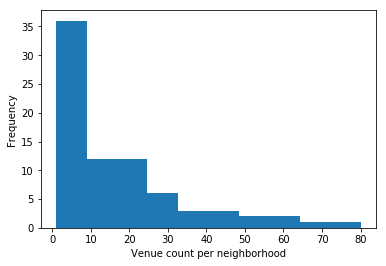

In [19]:
print('There are {} uniques venue categories.'.format(len(hh_venues['Venue Category'].unique())))

# plot a histogram
hh_venues_count = hh_venues.groupby('Neighborhood').count().iloc[:,0]
hh_venues_count.plot(kind='hist')  

plt.xlabel('Venue count per neighborhood')
# Optional: Save the histogram as a png file
# plt.savefig('Venue_Count_Histogram.png')

plt.show()

Let's also look for venue categories that describe Coffee Shops (should start with a 'C' for Café, Coffee etc.).

In [20]:
venue_categories = sorted(hh_venues['Venue Category'].unique().tolist())
venues_C = [category for category in venue_categories if (category.startswith('C'))]
venues_C

['Cable Car',
 'Cafeteria',
 'Café',
 'Cajun / Creole Restaurant',
 'Canal',
 'Candy Store',
 'Car Wash',
 'Carpet Store',
 'Check Cashing Service',
 'Cheese Shop',
 'Chinese Restaurant',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'College Theater',
 'Comedy Club',
 'Concert Hall',
 'Construction & Landscaping',
 'Convenience Store',
 'Cosmetics Shop',
 'Creperie',
 'Cuban Restaurant',
 'Cycle Studio']

Seems that there are two venue categories that label Coffe Shops: "**Café**" and "**Coffee Shop**". Let's get the total count of these two venue categories for each neighborhood and save it in a new dataframe called 'hh_cafes'. We can use these data later to label each neighborhood in the map with the number of coffee shops that are already present in that neighborhood (see 2.3).

In [21]:
hh_cafes = pd.DataFrame(columns = ['Neighborhood','Cafés'])

for neighborhood in hh.Neighborhood:

    neighborhood_venues = hh_venues[hh_venues.Neighborhood == neighborhood]
    neighborhood_cafes = neighborhood_venues[(neighborhood_venues['Venue Category']=='Café') | (
        neighborhood_venues['Venue Category']=='Coffee Shop')]
    
    hh_cafes = hh_cafes.append({'Neighborhood':neighborhood, 'Cafés':neighborhood_cafes.shape[0]}, ignore_index=True)

# Optional: Save hh_cafes to csv
# hh_cafes.to_csv('hh_cafes.csv',index=False)    
    
hh_cafes.head()

,Neighborhood,Cafés
0,Adams-Normandie,0
1,Arleta,0
2,Arlington Heights,0
3,Atwater Village,5
4,Beverly Crest,0


Let's also plot the number of returned cafés/coffe shops per neighborhood in a histogram.

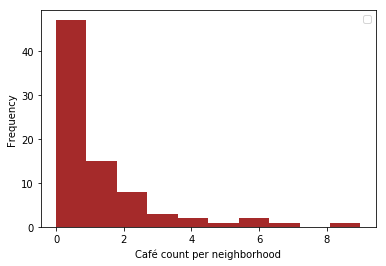

In [22]:
# plot histogram
hh_cafes.plot(kind='hist', color='brown')  

plt.xlabel('Café count per neighborhood')
plt.legend('')

# Optional: Save the histogram as a png file
# plt.savefig('Cafe_Count_Histogram.png')

plt.show()

Interesting. Seems that most neighborhoods have either no other only very few cafés yet. However, some neighborhoods seem to have already many cafés. Let's get the names of these neighborhoods with many cafés (>=5) and keep them in mind, since we wouldn't want to open our new study café in such café-rich neighborhoods.

In [23]:
hh_cafes.Neighborhood[hh_cafes.Cafés >= 5].tolist()

['Atwater Village', 'Echo Park', 'Koreatown', 'Los Feliz', 'Westwood']

Finally, let's also plot a histogram of the home prices to get an idea about the home price distribution.

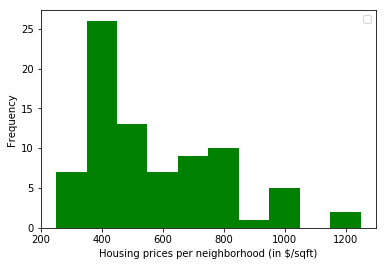

In [24]:
# plot histogram
hh.Price.plot(kind='hist',color='green')  

plt.xlabel('Housing prices per neighborhood (in $/sqft)')
plt.legend('')

# Optional: Save the histogram as a png file
# plt.savefig('Home_Price_Histogram.png')

plt.show()

Seems that some neighborhood have very high housing prices! Let's get the names of these neighborhoods with extremely high housing prices (>800 $/sqft) and keep them in mind, since we wouldn't want to open our new study café in such expensive neighborhoods.

In [25]:
hh.Neighborhood[hh.Price >= 800].tolist()

['Atwater Village',
 'Beverly Crest',
 'Beverlywood',
 'Brentwood',
 'Cheviot Hills',
 'Hollywood Hills',
 'Los Feliz',
 'Mar Vista',
 'Mid-City',
 'Pacific Palisades',
 'Pico-Robertson',
 'Silver Lake',
 'Venice']

#### Part 2.2: Clustering L.A.'s neighborhoods by venues

Now, we will use the venue data (see 1.2) to obtain the mean frequencies of the different venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters by the the k-means clustering algorithm.

We first create a dataframe with each neighborhood's mean frequencies of the different venue categories.

In [26]:
# one hot encoding
hh_onehot = pd.get_dummies(hh_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
hh_onehot['Neighborhood'] = hh_venues['Neighborhood'] 

# move district column to the first column
fixed_columns = [hh_onehot.columns[-1]] + list(hh_onehot.columns[:-1])
hh_onehot = hh_onehot[fixed_columns]

# group rows by district and by taking the mean of the frequency of occurrence of each category
hh_grouped = hh_onehot.groupby('Neighborhood').mean().reset_index()
print(hh_grouped.shape)
hh_grouped.head()

(78, 238)


,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Airport Service,Alternative Healer,American Restaurant,Arcade,Argentinian Restaurant,...,Toy / Game Store,Trail,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Wings Joint
0,Adams-Normandie,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,Arleta,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,Arlington Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,Atwater Village,0.0,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.022727,0.0,0.0
4,Beverly Crest,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


Let's also create a dataframe that display the top 10 venue categories in each neighborhood. Therefore, we first define a function to sort the venues in descending order.

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
print('Function ready!')

Function ready!


Now we use this function to build a new dataframe with the top 10 venue categories in each neighborhood.

In [28]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = hh_grouped['Neighborhood']

for ind in np.arange(hh_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hh_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams-Normandie,Sushi Restaurant,Mexican Restaurant,Taco Place,Fried Chicken Joint,Playground,Grocery Store,Wings Joint,Dive Shop,Doctor's Office,Donut Shop
1,Arleta,Taco Place,Wings Joint,Financial or Legal Service,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Electronics Store,Dumpling Restaurant
2,Arlington Heights,Art Gallery,Shop & Service,Donut Shop,Wings Joint,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop
3,Atwater Village,Coffee Shop,Vietnamese Restaurant,Liquor Store,Shipping Store,Pizza Place,Italian Restaurant,Bookstore,Boutique,Sandwich Place,Juice Bar
4,Beverly Crest,Home Service,Pool,Wings Joint,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Electronics Store,Dumpling Restaurant


Now let's cluster the neighborhoods by their venue frequencies using the k-means clustering algorithm from the sklearn library. As we do not know the optimal k for clustering, we first run the k-means clustering algorithm with different values for k and create an elbow plot that shows the winthin-cluster sum of squares (i.e. inertia or distortion) for each value of k.

In [29]:
# run k-means clustering with different values for k
from sklearn.metrics import silhouette_score

ks = range(1,16)
inertia = []
hh_grouped_clustering = hh_grouped.drop('Neighborhood', 1)

for k in ks:
    k_means = KMeans(n_clusters=k, random_state=3).fit(hh_grouped_clustering)
    inertia.append(k_means.inertia_)

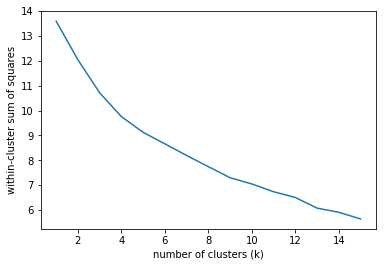

In [30]:
# elbow plot: show the within-cluster sum of squares (inertia or distortion), 
# i.e. the sum of squared distances of samples to their closest cluster center

plt.plot(ks,inertia)
plt.ylabel('within-cluster sum of squares')
plt.xlabel('number of clusters (k)')

# Optional: Save the elbow plot as a png file
# plt.savefig('Elbow_plot.png')

plt.show()

As we see in the plot, there is no clear "elbow" that shows us the optimal value of k for clustering. Note that I also tried alternative methods to determine the optimal k, e.g. the silhouette coefficient or the gap statistic (code not shown to keep the notebook cleaner). However, these methods also yielded no clear answer about the optimal value for k. Hence, the value for clustering was set to **k = 4**, based on the following rationale: On the one hand, we want more than 1-2 clusters to better distinguish the large number of neighborhoods based on their different venue characteristics. Yet, we also do not want too many clusters to keep the resulting cluster structure easily understandable (e.g. we do not want many unique clusters that only contain 1-2 neighborhoods each).

In [31]:
# run k-means clustering with k=4
kclusters = 4
kmeans = KMeans(n_clusters=kclusters, random_state=3).fit(hh_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.



In [32]:
# add clustering results to venues data
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
hh_merged = hh.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
hh_merged.head()

,Neighborhood,Price,Lat,Lon,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams-Normandie,424,34.0326,-118.3000,0.0,Sushi Restaurant,Mexican Restaurant,Taco Place,Fried Chicken Joint,Playground,Grocery Store,Wings Joint,Dive Shop,Doctor's Office,Donut Shop
1,Arleta,377,34.2505,-118.4338,1.0,Taco Place,Wings Joint,Financial or Legal Service,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Electronics Store,Dumpling Restaurant
2,Arlington Heights,250,34.0422,-118.3189,0.0,Art Gallery,Shop & Service,Donut Shop,Wings Joint,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop
3,Atwater Village,805,34.1173,-118.2614,0.0,Coffee Shop,Vietnamese Restaurant,Liquor Store,Shipping Store,Pizza Place,Italian Restaurant,Bookstore,Boutique,Sandwich Place,Juice Bar
4,Beverly Crest,982,34.1160,-118.4070,0.0,Home Service,Pool,Wings Joint,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Electronics Store,Dumpling Restaurant


Since we can't see all of the data, we're going to make sure that there are no instances of NaN as a cluster label, (i.e., if Foursquare returned no venues within the 500 m radius for these neighborhoods). Let's remove these neighborhoods with no cluster labels (if there are any) from the dataframe.

In [33]:
print('Before dropping, there are {} neighborhoods with NaN entries and {} neighborhoods without NaN entries.'.format(
    hh_merged.Cluster.isnull().sum(),hh_merged.Cluster.notnull().sum()))
hh_merged.dropna(subset=['Cluster'], axis=0, inplace=True)
hh_merged.reset_index(inplace=True, drop=True)
print('After dropping, there are {} neighborhoods with NaN entries and {} neighborhoods without NaN entries.'.format(
    hh_merged.Cluster.isnull().sum(),hh_merged.Cluster.notnull().sum()))

Before dropping, there are 2 neighborhoods with NaN entries and 78 neighborhoods without NaN entries.
After dropping, there are 0 neighborhoods with NaN entries and 78 neighborhoods without NaN entries.


Let's look at the first 5 rows of this dataframe.

In [34]:
hh_merged['Cluster'] = hh_merged['Cluster'].astype(int)
hh_merged.head()

,Neighborhood,Price,Lat,Lon,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams-Normandie,424,34.0326,-118.3000,0,Sushi Restaurant,Mexican Restaurant,Taco Place,Fried Chicken Joint,Playground,Grocery Store,Wings Joint,Dive Shop,Doctor's Office,Donut Shop
1,Arleta,377,34.2505,-118.4338,1,Taco Place,Wings Joint,Financial or Legal Service,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Electronics Store,Dumpling Restaurant
2,Arlington Heights,250,34.0422,-118.3189,0,Art Gallery,Shop & Service,Donut Shop,Wings Joint,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop
3,Atwater Village,805,34.1173,-118.2614,0,Coffee Shop,Vietnamese Restaurant,Liquor Store,Shipping Store,Pizza Place,Italian Restaurant,Bookstore,Boutique,Sandwich Place,Juice Bar
4,Beverly Crest,982,34.1160,-118.4070,0,Home Service,Pool,Wings Joint,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Electronics Store,Dumpling Restaurant


Now that we have our different clusters, let's further examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we try to assign a name to each cluster (despite the remaining diversity of venue categories for each cluster).

**Cluster 0: Restaurants**

We name this cluster "Restaurants", as fast food restaurants, Mexican, Italian, and Sushi restaurants are the most common venue categories in this cluster (not including "Taco Place" in here, as that is a large segment of non-restaurant food in L.A. This cluster consists of 74 neighborhoods.

In [35]:
hh_cluster0 = hh_merged.loc[hh_merged['Cluster']==0, hh_merged.columns[[0] + list(range(5,10))]]
print('There are {} neighborhoods in Cluster 0.'.format(hh_cluster0.shape[0]))
hh_cluster0

There are 74 neighborhoods in Cluster 0.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adams-Normandie,Sushi Restaurant,Mexican Restaurant,Taco Place,Fried Chicken Joint,Playground
2,Arlington Heights,Art Gallery,Shop & Service,Donut Shop,Wings Joint,Dive Bar
3,Atwater Village,Coffee Shop,Vietnamese Restaurant,Liquor Store,Shipping Store,Pizza Place
4,Beverly Crest,Home Service,Pool,Wings Joint,Diner,Fast Food Restaurant
5,Beverlywood,Business Service,Park,Burrito Place,Concert Hall,Wings Joint
6,Boyle Heights,Gym,Seafood Restaurant,Stadium,Burger Joint,Bakery
7,Brentwood,Italian Restaurant,Gym / Fitness Center,Photography Studio,Farmers Market,Sandwich Place
8,Canoga Park,Mexican Restaurant,Pharmacy,Ice Cream Shop,Sushi Restaurant,Food
9,Century City,Food Truck,Hotel,Café,Movie Theater,Japanese Restaurant
10,Chatsworth,Electronics Store,Carpet Store,Trail,Movie Theater,Wings Joint


**Cluster 1: Taco Places**

We name this cluster "Taco Places" based on the observation that in both neighborhoods of this cluster, taco places are the most common venue.

In [36]:
hh_cluster1 = hh_merged.loc[hh_merged['Cluster']==1, hh_merged.columns[[0] + list(range(5,10))]]
print('There are {} neighborhoods in Cluster 1.'.format(hh_cluster1.shape[0]))
hh_cluster1

There are 2 neighborhoods in Cluster 1.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Arleta,Taco Place,Wings Joint,Financial or Legal Service,Filipino Restaurant,Fast Food Restaurant
55,Sawtelle,Taco Place,Wings Joint,Financial or Legal Service,Filipino Restaurant,Fast Food Restaurant


**Cluster 2: Parks**

We name this cluster "Parks", since there is only one neighborhood in this cluster and its most common venue is a park.

In [37]:
hh_cluster2 = hh_merged.loc[hh_merged['Cluster']==2, hh_merged.columns[[0] + list(range(5,10))]]
print('There is {} neighborhoods in Cluster 2.'.format(hh_cluster2.shape[0]))
hh_cluster2

There is 1 neighborhoods in Cluster 2.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
48,Panorama City,Park,Wings Joint,Discount Store,Filipino Restaurant,Fast Food Restaurant


**Cluster 3: Grocery Stores**

We name this cluster "Grocery Stores", since the grocery store is the most common venue in this neighborhood (although it's hard to really define such a thing as there is only one neighborhood in this cluster, like the cluster above.)

In [38]:
hh_cluster3 = hh_merged.loc[hh_merged['Cluster']==3, hh_merged.columns[[0] + list(range(5,10))]]
print('There are {} neighborhoods in Cluster 3.'.format(hh_cluster3.shape[0]))
hh_cluster3

There are 1 neighborhoods in Cluster 3.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
61,Sylmar,Grocery Store,Wings Joint,Discount Store,Filipino Restaurant,Fast Food Restaurant


Let's now insert the cluster labels into a new column in the dataframe.

In [39]:
hh_merged2 = hh_merged

hh_merged2['ClusterName'] = hh_merged2.Cluster
hh_merged2.ClusterName.replace(0,'Restaurants',inplace=True)
hh_merged2.ClusterName.replace(1,'Taco Places',inplace=True)
hh_merged2.ClusterName.replace(2,'Parks',inplace=True)
hh_merged2.ClusterName.replace(3,'Grocery Stores',inplace=True)

hh_merged3 = hh_merged2[hh_merged2['ClusterName'] == 'Cluster'].copy()


# move neighborhood column to the first column
fixed_columns = list(hh_merged2.columns[0:5]) + ['ClusterName'] + list(hh_merged2.columns[5:15])
hh_merged2 = hh_merged2[fixed_columns]
hh_merged2.head()

,Neighborhood,Price,Lat,Lon,Cluster,ClusterName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams-Normandie,424,34.0326,-118.3000,0,Restaurants,Sushi Restaurant,Mexican Restaurant,Taco Place,Fried Chicken Joint,Playground,Grocery Store,Wings Joint,Dive Shop,Doctor's Office,Donut Shop
1,Arleta,377,34.2505,-118.4338,1,Taco Places,Taco Place,Wings Joint,Financial or Legal Service,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Electronics Store,Dumpling Restaurant
2,Arlington Heights,250,34.0422,-118.3189,0,Restaurants,Art Gallery,Shop & Service,Donut Shop,Wings Joint,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop
3,Atwater Village,805,34.1173,-118.2614,0,Restaurants,Coffee Shop,Vietnamese Restaurant,Liquor Store,Shipping Store,Pizza Place,Italian Restaurant,Bookstore,Boutique,Sandwich Place,Juice Bar
4,Beverly Crest,982,34.1160,-118.4070,0,Restaurants,Home Service,Pool,Wings Joint,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,Electronics Store,Dumpling Restaurant


#### Part 2.3: Visualization of results in a choropleth map

Now let's visualize the results using Folium. For this, we will label each neighborhood with its cluster label, its number of cafés, and its exact housing price (if available) and superimpose this information on the choropleth map using the housing prices of the neighborhoods.

In [140]:
# create map
hh_lat = 34.0505
hh_lon = -118.1614
hh_zoom = 10

hh_map = folium.Map(location=[hh_lat, hh_lon], zoom_start=hh_zoom)

# set colors for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
mycolors = ['#7a7979', '#00b5eb', '#8000ff', '#363136', '#ff0000']

# color districts by housing price
hh_map.choropleth(
    geo_data=la_geo,
    data=la_Data,
    columns=['Neighborhood', 'Price'],
    key_on='feature.properties.name',
    fill_color='BuPu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Housing prices in L.A.')

# add markers for each university to map
for lat, lon, uni in zip(la_unis['Lat'], la_unis['Lon'], la_unis['University']):
    label = uni
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(hh_map)
    
# add markers to the map containing for each neighborhood the cluster label, housing price, and number of cafés
for lat, lon, neighborhood, price, cluster, clabel in zip(hh_merged2['Lat'], hh_merged2['Lon'], hh_merged2['Neighborhood'], hh_merged2['Price'], hh_merged2['Cluster'], hh_merged2['ClusterName']):
    ncafes = int(hh_cafes.Cafés[hh_cafes.Neighborhood==neighborhood])
    label = folium.Popup(str(neighborhood) + ', ' + str(ncafes) + ' Cafés, ' + str(price) + ' $/sqft (Cluster ' + str(cluster) + ': ' + clabel + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=mycolors[cluster],
        fill=True,
        fill_color=mycolors[cluster],
        fill_opacity=0.7).add_to(hh_map)

    
# display map
hh_map

Above, we have a nice visualization of L.A.'s neighborhoods along with their venue characteristics, number of cafés, housing prices, and the locations of universities. This map should aid investors in finding the optimal place to open a new study café. From a look on the map, it seems that the "#" neighborhoods "_______", "_______", "_______", and "______" might be good locations to open the new study café for several reasons:

- They are lively neighborhoods with many other Restaurant venues around, but not too many cafés (<4).
- They have one or more universities nearby.
- They have moderate housing prices (<800 $/sqft).

Let's finally summarize the basic characteristics of these "#" selected neighborhoods in order to present this list to potential investors.